In [1]:
import pandas as pd
import numpy as np
import os
from collections import Counter
import os
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms
from torchvision.transforms import functional as t_F
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
os.environ["TORCH_HOME"] = "D:\Yasin\.checkpoints"
data_root = 'D:\Data'

In [3]:
train_df = pd.read_excel(os.path.join(data_root, 'Meta/train_main_features_75.xlsx'), keep_default_na=False, na_values=[""], dtype = str)
test_df = pd.read_excel(os.path.join(data_root, 'Meta/test_main_features_75.xlsx'), keep_default_na=False, na_values=[""], dtype = str)
train_hpv = pd.read_excel(os.path.join(data_root, 'Meta/train_HPV_features_75.xlsx'),)
test_hpv = pd.read_excel(os.path.join(data_root, 'Meta/test_HPV_features_75.xlsx'),)

In [5]:
all_data = pd.concat([train_df, test_df])

In [6]:
train_df.head()

,Patient ID,jpg_file,xlsx_file,Date,Adeno:conclusive,AA:Color,AA:Margin of aceto acid,AA:Surface,AA:Size,Vessels:Punctuation,...,EXTRA INFO,Age,Smoking,Drink,SD,Married,#Partner,Pop,Abnormality(Impression),Abnormality(BX)
0,14.976,14.976/14_976_A.TIF,14.976.xlsx,1403.03,NO,Snowy White,Geographical,Flat,Small,Fine,...,NaN,37,NaN,NaN,NaN,NaN,NaN,NaN,True,True
1,19.202,19.202/19_202_A.JPG,19.202.xlsx,1404.02,No,Snowy White,Geographical,Flat,Small,Fine,...,NaN,40,Yes,Yes,NaN,No,4,NaN,True,True
2,19.503,19_503/19_503_A4.JPG,19.503.xlsx,NaN,No,Snowy White,Geographical,Flat,Large,Fine,...,NaN,42,No,No,27,Yes,1,NaN,True,True
3,17.282,17_282/17_282_A3.TIF,17.282.xlsx,1402.12,Yes,Pink,None,None,None,None,...,NaN,38,NaN,NaN,NaN,NaN,NaN,NaN,True,True
4,17.590,17_590/17_590_A1.JPG,17.590.xlsx,1403.03,Yes,Pink,None,None,None,None,...,NaN,45,No,No,NaN,Yes,NaN,NaN,False,False


In [8]:
flag = all_data['Logul'].isna()
print(flag.sum())

flag_pos = (all_data['Logul'] == 'Positive') | (all_data['Logul'] == 'POSITIVE')
flag_neg = (all_data['Logul'] == 'Negative') | (all_data['Logul'] == 'Negetive')
flag_ab_imp = (all_data['Abnormality(Impression)'] == 'True')
flag_ab_bx = (all_data['Abnormality(BX)'] == 'True')

print(flag_pos.sum(), flag_neg.sum(), flag_ab_imp.sum(), flag_ab_bx.sum())
print((flag_pos & flag_ab_imp).sum(), (flag_pos & ~flag_ab_imp).sum(), (flag_neg & flag_ab_imp).sum(), (flag_neg & ~flag_ab_imp).sum())
print((flag_pos & flag_ab_bx).sum(), (flag_pos & ~flag_ab_bx).sum(), (flag_neg & flag_ab_bx).sum(), (flag_neg & ~flag_ab_bx).sum())

13
220 182 255 220
204 16 41 141
181 39 30 152


In [9]:
print(all_data['Logul'].unique())
print(all_data['Pop'].unique())

['Positive' 'Negative' nan 'POSITIVE' 'Negetive']
[nan 'NILM' 'LSIL' 'ASCH' 'AGC' 'ASCUS' 'ADENO-CARCINOMA' 'HSIL'
 'UNSATISFACTORY' 'SCC']


In [10]:
all_data['Patient ID'][all_data['Pop'] == 'UNSATISFACTORY']

162    18.875
Name: Patient ID, dtype: object

In [11]:
train_df.loc[train_df['Logul'] == 'Negetive', 'Logul'] = 'Negative'
train_df.loc[train_df['Logul'] == 'POSITIVE', 'Logul'] = 'Positive'
test_df.loc[test_df['Logul'] == 'Negetive', 'Logul'] = 'Negative'
test_df.loc[test_df['Logul'] == 'POSITIVE', 'Logul'] = 'Positive'

In [12]:
test_hpv.head()

,3,6,11,14,16,18,26,31,32,33,...,75,80,81,82,83,84,89,90,91,others
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
HPV_col = ['16', '18', 'Others', "No"]
def prepare_hpv(df):
    hpv_df = pd.DataFrame(data= np.array([[0]*len(HPV_col)]*len(df)) , columns=HPV_col)
    hpv_df.iloc[df['16'].isna()] = np.nan
    hpv_df['16'] = df['16']
    hpv_df['18'] = df['18']
    others = df.drop(columns=['16', '18']).sum(axis=1, skipna = False)
    hpv_df.loc[others.notna() & others.astype(bool), 'Others'] = 1
    pos = df.sum(axis=1, skipna = False)
    pos_flag = pos.astype(bool) & df['16'].notna()
    hpv_df.loc[pos.notna() & ~pos_flag, 'No'] = 1
    return hpv_df

In [14]:
train_hpv = prepare_hpv(train_hpv)
test_hpv = prepare_hpv(test_hpv)

In [15]:
test_hpv.head()

,16,18,Others,No
0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,0.0,1.0,1.0,0.0
4,NaN,NaN,NaN,NaN


In [16]:
extra_train_df = pd.concat([train_df['Age'],train_df['Logul'],train_df['Pop'], train_hpv], axis = 1)
extra_test_df = pd.concat([test_df['Age'],test_df['Logul'],test_df['Pop'], test_hpv], axis = 1)

extra_train_df["Age"] = pd.to_numeric(extra_train_df["Age"], errors="coerce").astype("Int64")
extra_test_df["Age"] = pd.to_numeric(extra_test_df["Age"], errors="coerce").astype("Int64")

In [17]:
extra_test_df.head()

,Age,Logul,Pop,16,18,Others,No
0,31,Positive,NILM,0.0,0.0,0.0,1.0
1,40,Negative,NILM,1.0,0.0,0.0,0.0
2,42,Positive,HSIL,1.0,0.0,0.0,0.0
3,30,Positive,NILM,0.0,1.0,1.0,0.0
4,41,Negative,NaN,NaN,NaN,NaN,NaN


In [18]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

class Imputation:
    def __init__(self):
        # Learned statistics
        self.age_median = None
        self.age_scaler = None

    # ==============================================================
    #                       FIT
    # ==============================================================
    def fit(self, df):
        """
        Learn statistics from the training dataset only.
        """
        # ---- Fit Age median ----
        self.age_median = df["Age"].median()

        # ---- Fit StandardScaler using a DataFrame (keeps feature names) ----
        age_filled = df[["Age"]].fillna(self.age_median)
        self.age_scaler = StandardScaler().fit(age_filled)

        return self


    PAP_MAP = {
        "NILM": 0,
        "ENDOMETRII-CELL":0.75,
        "ASCUS": 1,
        "LSIL": 2,
        "ASCH": 3,
        "HSIL": 4,
        "SCC": 4.5,
        "AGC": 5,
        "AGCNOS": 5.5,
        "AGC-NEOPLASI": 6,
        "ADENO-CARCINOMA": 6.5,
        "UNSATISFACTORY": 7}

    # ==============================================================
    #                   TRANSFORM HELPERS
    # ==============================================================

    # ---------- HPV ENCODING ----------
    @staticmethod
    def encode_hpv(x):
        if pd.isna(x) or str(x).strip() == "":
            return 0     # Missing → neutral
        x = str(x).strip().lower()
        if x == "No":
            return -2
        if x in ["Others"]:
            return -1
        if x in ["18", "hpv18"]:
            return 1
        if x in ["16", "hpv16"]:
            return 2
        return -1  # Unknown → treat as low risk

    def encode_hpv_from_columns(self, row):
        """
        row: a pandas Series with columns:
            '16', '18', 'Others'
        """
        # If all three are missing -> neutral (0)
        if row[["16", "18", "Others", "No"]].isna().all():
            return 0

        has_16 = bool(row.get("16", 0))
        has_18 = bool(row.get("18", 0))
        has_oth = bool(row.get("Others", 0))
        no_hpv = bool(row.get("No", 0))

        # No HPV at all (all zeros) -> -2
        if not has_16 and not has_18 and not has_oth:
            return -2

        codes = []
        if has_16:
            return 2.5
        if has_18:
            return 2
        if has_oth:
            return 1


    # ---------- PAP SMEAR ----------
    @staticmethod
    def encode_pap_category(x):
        if pd.isna(x) or str(x).strip() == "":
            return np.nan

        key = str(x)
        if key in Imputation.PAP_MAP:
            return Imputation.PAP_MAP[key]

        # Unknown category -> conservative choice (ASCUS)
        return 1

    # ---------- LUGOL ----------
    @staticmethod
    def encode_lugol_category(x):
        if pd.isna(x) or str(x).strip() == "":
            return 0
        x = str(x).strip().lower()
        if x == "negative":
            return -1
        if x == "positive":
            return 1
        return 0  # unknown → treat as negative

    # ==============================================================
    #                     TRANSFORM
    # ==============================================================
    def transform(self, df):
        """
        Apply imputations + encodings to any dataframe.
        Requires .fit() to have been called first.
        Returns a NEW dataframe (does not modify original df).
        """
        df = df.copy()

        # ========================================================
        # AGE
        # ========================================================
        df["Age"] = df["Age"].fillna(self.age_median)
        df["Age"] = self.age_scaler.transform(df[["Age"]])

        # ========================================================
        # HPV ENCODING
        # ========================================================
        df["HPV_encoded"] = df.apply(self.encode_hpv_from_columns, axis=1)


        # ========================================================
        # PAP SMEAR
        # ========================================================
        df["Pap_level_raw"] = df["Pop"].apply(self.encode_pap_category)
        df["Pap_missing"] = df["Pap_level_raw"].isna().astype(int)
        df["Pap_level"] = df["Pap_level_raw"].fillna(0)
        df.drop(columns=["Pap_level_raw"], inplace=True)

        # ========================================================
        # LUGOL
        # ========================================================
        df["Lugol"] = df["Logul"].apply(self.encode_lugol_category)
        # df["Lugol_missing"] = df["Lugol_raw"].isna().astype(int)
        # df["Lugol_value"] = df["Lugol_raw"].fillna(0)
        # df.drop(columns=["Lugol_raw"], inplace=True)

        # ========================================================
        # Final selected columns (tabular features)
        # ========================================================
        final_cols = [
            "Age",
            "HPV_encoded",
            "Pap_level",
            "Pap_missing",
            "Lugol",
        ]

        return df[final_cols].astype(np.float32)

    # ==============================================================
    #                FIT + TRANSFORM CONVENIENCE
    # ==============================================================
    def fit_transform(self, df):
        self.fit(df)
        return self.transform(df)


In [19]:
imp = Imputation()
X_train_tab = imp.fit_transform(extra_train_df)
X_test_tab = imp.transform(extra_test_df)

In [20]:
X_test_tab.head()

,Age,HPV_encoded,Pap_level,Pap_missing,Lugol
0,-0.451529,-2.0,0.0,0.0,1.0
1,0.728641,2.5,0.0,0.0,-1.0
2,0.990901,2.5,4.0,0.0,1.0
3,-0.582659,2.0,0.0,0.0,1.0
4,0.859771,0.0,0.0,1.0,-1.0


In [21]:
train_df = pd.concat([train_df[['Patient ID', 'jpg_file', 'Abnormality(Impression)', 'Abnormality(BX)']], X_train_tab], axis = 1)
test_df = pd.concat([test_df[['Patient ID', 'jpg_file', 'Abnormality(Impression)', 'Abnormality(BX)']], X_test_tab], axis = 1)

In [ ]:
# class ColposcopyBaseDataset(Dataset):
#     def __init__(self, dataframe, root_dir, cropped_folder="Cropped Folder", image_size=224, augment=False):
#         self.data = dataframe.reset_index(drop=True)
#         self.root_dir = root_dir
#         self.cropped_folder = cropped_folder
#         self.data["label"] = (self.data["Impression"].str.lower() == "normal").astype(int)
#         self.augment = augment
#         self.image_size = image_size

#         # Base transform (resize + normalization)
#         self.base_transform = transforms.Compose([
#             transforms.Resize((image_size, image_size)),
#             transforms.ToTensor(),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                  std=[0.229, 0.224, 0.225])
#         ])

#         # Only define deterministic augmentations for training
#         self.rotations = [0, 90, 180, 270]
#         self.flips = [(False, False), (True, False), (False, True), (True, True)]
#         self.num_aug_per_image = len(self.rotations) * len(self.flips) if augment else 1

#     def __len__(self):
#         return len(self.data) * self.num_aug_per_image

#     def __getitem__(self, idx):
#         img_idx = idx // self.num_aug_per_image if self.augment else idx
#         aug_idx = idx % self.num_aug_per_image if self.augment else 0
#         row = self.data.iloc[img_idx]

#         img_path = os.path.join(self.root_dir, self.cropped_folder,
#                                 str(row["Patient ID"]), row["jpg_file"])
#         label = row["label"]
#         image = Image.open(img_path).convert("RGB")

#         # Apply deterministic augmentations only if augment=True
#         if self.augment:
#             rot = self.rotations[aug_idx // len(self.flips)]
#             hflip, vflip = self.flips[aug_idx % len(self.flips)]
#             if rot:
#                 image = image.rotate(rot)
#             if hflip:
#                 image = t_F.hflip(image)
#             if vflip:
#                 image = t_F.vflip(image)

#         image = self.base_transform(image)
#         return image, torch.tensor(label, dtype=torch.long)


In [22]:
import os
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.transforms import functional as F
from PIL import Image

class ColposcopyCachedDataset(Dataset):
    """
    Preloads all images (and their augmentations if needed) into memory.
    - augment=True → 16 deterministic variants per image (4 rotations × 4 flips)
    - augment=False → only original resized + normalized image
    """
    def __init__(self, dataframe, root_dir, cropped_folder="Cropped Folder",
                 image_size=224, augment=False, BX_based =False, Extra_feats= None, return_extra = True):
        self.data = dataframe.reset_index(drop=True)
        self.root_dir = root_dir
        self.cropped_folder = cropped_folder
        self.augment = augment
        self.BX_based = BX_based
        self.Extra_feats_cols = Extra_feats
        self.return_extra = return_extra

        self.rotations = [0, 90, 180, 270]
        self.flips = [(False, False), (True, False), (False, True), (True, True)]
        self.augment_transforms = [(rot, flip) for rot in self.rotations for flip in self.flips]
        # print(self.augment_transforms)

        self.base_transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

        # Preload all images once
        self.cached_images, self.cached_labels, self.extra_feats = self._preload_all()

    def _load_image(self, img_path):
        """Safely open an image and convert to RGB"""
        with Image.open(img_path) as img:
            return img.convert("RGB")

    def _preload_all(self):
        """Load all images (+ augmentations if requested) into memory"""
        images, labels, extra_feats = [], [], []
        if self.BX_based: label_flag = "Abnormality(BX)"
        else: label_flag = "Abnormality(Impression)"

        for _, row in self.data.iterrows():
            label = torch.tensor(row[label_flag] == 'True', dtype=torch.long)
            extra_feat = torch.tensor(row[self.Extra_feats_cols].astype(np.float32).values) if self.Extra_feats_cols is not None else None
            img_path = os.path.join(self.root_dir, self.cropped_folder,str(row["Patient ID"]), row["jpg_file"])
            try:
                image = self._load_image(img_path)
            except Exception as e:
                print(f"⚠️ Error loading {img_path}: {e}")
                continue

            if self.augment:
                augment_idx = [0]+ np.random.choice(range(16), size= self.augment-1, replace=False).tolist()
                for idx in augment_idx:
                    rot, (hflip, vflip) = self.augment_transforms[idx]
                    aug_img = image.copy()
                    if rot:
                        aug_img = aug_img.rotate(rot)
                    if hflip:
                        aug_img = t_F.hflip(aug_img)
                    if vflip:
                        aug_img = t_F.vflip(aug_img)
                    tensor_img = self.base_transform(aug_img)
                    images.append(tensor_img)
                    labels.append(label)
                    extra_feats.append(extra_feat)
            else:
                tensor_img = self.base_transform(image)
                images.append(tensor_img)
                labels.append(label)
                extra_feats.append(extra_feat)

        print(f"✅ Cached {len(images)} tensors "
              f"({len(images)//len(self.data)}× per original)")
        return images, labels, extra_feats

    def __len__(self):
        return len(self.cached_images)

    def __getitem__(self, idx):
        return self.cached_images[idx], self.extra_feats[idx], self.cached_labels[idx]

In [13]:
import os
from PIL import Image
from torch.utils.data import Dataset

class KaggleImageDataset(Dataset):
    def __init__(self, dataroot, transform=None, class_to_idx=None):
        """
        dataroot: path to Train / Validation / Test folder
        transform: torchvision transforms (no augmentation)
        """
        self.transform = transform

        if class_to_idx is None:
            self.class_to_idx = {
                "Normal": 0,
                "Abnormal": 1
            }
        else:
            self.class_to_idx = class_to_idx

        # STORE ACTUAL IMAGES AND LABELS
        self.images = []
        self.labels = []

        for class_name, label in self.class_to_idx.items():
            class_dir = os.path.join(dataroot, class_name)
            if not os.path.isdir(class_dir):
                continue

            for fname in os.listdir(class_dir):
                if fname.lower().endswith((".jpg", ".jpeg", ".png", ".bmp")):
                    img_path = os.path.join(class_dir, fname)

                    # 🔴 IMAGE IS READ HERE (NOT IN __getitem__)
                    img = Image.open(img_path).convert("RGB")

                    if self.transform is not None:
                        img = self.transform(img)

                    self.images.append(img)
                    self.labels.append(label)

        print(f"Loaded {len(self.images)} images into memory from {dataroot}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # ONLY INDEXING — NO IO
        return self.images[idx], torch.tensor([0]), self.labels[idx]


In [31]:
class Bsaic_Dataset(Dataset):
    def __init__(self, features, extras, labels):
        # Convert numpy arrays to torch tensors
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.extras = torch.tensor(extras, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.extras[idx], self.labels[idx]

In [19]:
from torch.utils.data import ConcatDataset
from torchvision import transforms


image_size=224

# --------------------------------------------------
# Transforms (NO augmentation)
# -------------------------------------------------
base_transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
        ])

data_name = "Dataset Colposcopy images/Splitdata"  # <-- change this

# --------------------------------------------------
# Train + Validation
# --------------------------------------------------
train_dataset = KaggleImageDataset(
    dataroot=os.path.join(data_root, data_name, "Train"),
    transform=base_transform
)

val_dataset = KaggleImageDataset(
    dataroot=os.path.join(data_root, data_name, "Validation"),
    transform=base_transform
)

full_train_dataset = ConcatDataset([train_dataset, val_dataset])

print(f"Total training samples: {len(full_train_dataset)}")

# --------------------------------------------------
# Test
# --------------------------------------------------
test_dataset = KaggleImageDataset(
    dataroot=os.path.join(data_root, data_name, "Test"),
    transform=base_transform
)

print(f"Total test samples: {len(test_dataset)}")


Loaded 1822 images into memory from D:\Data\Dataset Colposcopy images/Splitdata\Train
Loaded 391 images into memory from D:\Data\Dataset Colposcopy images/Splitdata\Validation
Total training samples: 2213
Loaded 392 images into memory from D:\Data\Dataset Colposcopy images/Splitdata\Test
Total test samples: 392


In [20]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    full_train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0
)


In [ ]:
# from torch.utils.data import random_split, DataLoader
# import torch

# batch_size=16
# split_ratio=0.7
# image_size=518
# extra_feat_cols = ['Age', 'Lugol', 'HPV_encoded',	'Pap_level', 'Pap_missing']


# # Build datasets
# train_dataset = ColposcopyCachedDataset(train_df, root, augment= 4, image_size=image_size, Extra_feats= extra_feat_cols)
# test_dataset = ColposcopyCachedDataset(test_df, root, augment=False, image_size=image_size, Extra_feats= extra_feat_cols)

# # Build dataloaders
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

✅ Cached 1236 tensors (4× per original)
✅ Cached 106 tensors (1× per original)


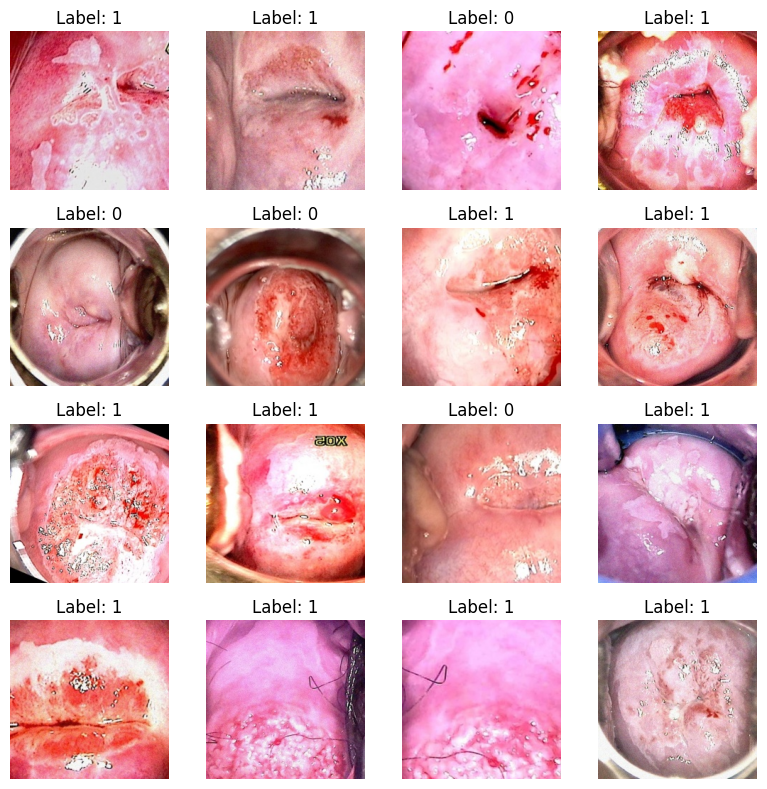

In [21]:
import matplotlib.pyplot as plt

def show_all_augmentations(dataset, img_idx):
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i in range(16):
        img, _, _ = dataset[img_idx * 16 + i]
        axes[i // 4, i % 4].imshow(img.permute(1, 2, 0).numpy() * 0.5 + 0.5)
        axes[i // 4, i % 4].axis('off')
    plt.show()

def show_first_16_from_batch(batch):
    images, _, labels = batch

    fig, axes = plt.subplots(4, 4, figsize=(8, 8))

    for i in range(16):
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = img.clip(0, 1)
        label = labels[i].item()

        axes[i // 4, i % 4].imshow(img)
        axes[i // 4, i % 4].set_title(f"Label: {label}")
        axes[i // 4, i % 4].axis("off")

    plt.tight_layout()
    plt.show()

# show_all_augmentations(train_dataset, 0)
batch = next(iter(train_loader))
show_first_16_from_batch(batch)


### base model

In [22]:
def build_vgg16(num_classes=2):
    model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
    for param in model.features.parameters():
        param.requires_grad = False  # freeze backbone
    dim = 4096
    model.classifier[6] = nn.Linear(4096, num_classes)
    return model

def build_resnet152(num_classes=2):
    model = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V1)
    for param in list(model.children())[:-1]:
        for p in param.parameters():
            p.requires_grad = False
    dim = model.fc.in_features
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

### model with PCA

In [23]:
class DinoV2Backbone(nn.Module): #input: 518*518
    def __init__(self, model_name="dinov2_vitb14"):
        super().__init__()
        self.backbone = torch.hub.load(
            'facebookresearch/dinov2',
            model_name,
            pretrained=True
        )
        # Freeze
        for p in self.backbone.parameters():
            p.requires_grad = False

    def forward(self, x, extra):
        # x: (B,3,H,W)
        with torch.no_grad():
            feats = self.backbone(x)   # (B,768)
        return feats


In [6]:
def build_vgg16_feature_extractor():
    model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
    for param in model.features.parameters():
        param.requires_grad = False  # freeze backbone
    dim =  model.classifier[6].in_features
    model.classifier[6] = nn.Identity()
    return model, dim

def build_resnet152_feature_extractor():
    model = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V1)
    for param in list(model.children())[:-1]:
        for p in param.parameters():
            p.requires_grad = False
    dim = model.fc.in_features
    model.fc = nn.Identity()
    return model, dim

def build_Dinov2B_feature_extractor():
    model = DinoV2Backbone()
    dim = 768
    return model, dim

In [24]:
def extract_features(dataloader, feature_extractor, device="cuda"):
    features, extras, labels = [], [], []
    feature_extractor.to(device)
    feature_extractor.eval()
    with torch.no_grad():
        for imgs, extra, lbls in dataloader:
            imgs = imgs.to(device)
            feats = feature_extractor(imgs)
            feats = feats.view(feats.size(0), -1)  # flatten
            features.append(feats.cpu().numpy())
            labels.append(lbls.numpy())
            extras.append(extra.numpy())
    features = np.concatenate(features)
    labels = np.concatenate(labels)
    extras = np.concatenate(extras)
    return features, extras, labels

In [25]:
from sklearn.decomposition import PCA

def apply_pca(train_feats, test_feats, pca, n_components=128):
    train_pca = pca.fit_transform(train_feats)
    test_pca = pca.transform(test_feats)
    explained = np.sum(pca.explained_variance_ratio_) * 100
    print(f"PCA reduced dimension → {n_components}, preserving {explained:.2f}% variance")
    return train_pca, test_pca, pca


In [26]:
# model, dim = build_vgg16_feature_extractor()
model, dim = build_resnet152_feature_extractor()
# model, dim = build_Dinov2B_feature_extractor()

train_feats, train_extra, train_labels = extract_features(train_loader, model)
test_feats, test_exrta, test_labels = extract_features(test_loader, model)

In [27]:
torch.save({"data": train_feats, "extra": train_extra,"label":train_labels}, f"{data_root}/Meta/Kaggle0_resnet152_features_train.pt")
torch.save({"data": test_feats, "extra": test_exrta, "label": test_labels}, f"{data_root}/Meta/Kaggle0_resnet152_features_test.pt")

In [28]:

obj = torch.load(f"{data_root}/Meta/resnet152_features_4augment_train.pt", weights_only=False)
train_feats, train_extra, train_labels = obj["data"], obj["extra"], obj["label"]

obj = torch.load(f"{data_root}/Meta/resnet152_features_test.pt", weights_only=False)
test_feats, test_exrta, test_labels = obj["data"], obj["extra"], obj["label"]

In [ ]:
# pca_dim = 128
# pca = PCA(n_components=pca_dim, whiten=True, random_state=42)


In [29]:
# train_pca, test_pca, pca = apply_pca(train_feats, test_feats, pca, n_components=pca_dim)
train_pca, test_pca = train_feats, test_feats

In [32]:
# Build datasets
# extra_feat_cols = ['Age', 'Lugol', 'HPV_encoded',	'Pap_level', 'Pap_missing']
# train_dataset_pca = Bsaic_Dataset(train_pca, train_extra[:,[0,2,3,4]], train_labels)
# test_dataset_pca = Bsaic_Dataset(test_pca, test_exrta[:,[0,2,3,4]], test_labels)


train_dataset_pca = Bsaic_Dataset(train_pca, train_extra, train_labels)
test_dataset_pca = Bsaic_Dataset(test_pca, test_exrta, test_labels)

# Build dataloaders
train_loader_pca = DataLoader(train_dataset_pca, batch_size=16, shuffle=True, num_workers=0)
test_loader_pca  = DataLoader(test_dataset_pca, batch_size=32, shuffle=False, num_workers=0)


In [33]:
import torch.nn as nn
import torch.nn.functional as F

class TabularAdapter(nn.Module):
    def __init__(self, in_dim=5, hidden_dims=[16, 32], dropout=0.1):
        super().__init__()
        dims = [in_dim] + hidden_dims
        layers = []
        for i in range(len(dims)-1):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

class ResidualMLPHead(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64], num_classes=2, dropout=0.3):
        super().__init__()
        self.dims = [input_dim] + hidden_dims
        self.layers = nn.ModuleList()

        for i in range(len(self.dims) - 1):
            self.layers.append(
                nn.Sequential(
                    nn.Linear(self.dims[i], self.dims[i+1]),
                    nn.ReLU(),
                    nn.Dropout(dropout)
                )
            )

        self.fc = nn.Linear(self.dims[-1], num_classes)

    def forward(self, x):
        for i in range(len(self.layers)):
            out = self.layers[i](x)
            if self.dims[i] == self.dims[i+1]:
                x = out + x   # residual
            else:
                x = out
        return self.fc(x)

class MultiModalClassifier(nn.Module):
    def __init__(
        self,
        img_dim,                  # e.g. 128
        tab_dim=5,                # number of tabular features
        tab_hidden=[16, 32],      # adapter sizes
        head_hidden=[128, 64],    # classifier hidden layers
        num_classes=2,
        dropout=0.3
    ):
        super().__init__()

        # Tabular adapter: 6 -> 16 -> 32
        self.tab_adapter = TabularAdapter(
            in_dim=tab_dim,
            hidden_dims=tab_hidden,
            dropout=dropout
        )

        # Final fused feature dimension = image + tabular
        fused_dim = img_dim + tab_hidden[-1]

        # Residual classifier MLP
        self.classifier = ResidualMLPHead(
            input_dim=fused_dim,
            hidden_dims=head_hidden,
            num_classes=num_classes,
            dropout=dropout
        )

    def forward(self, img_feat, tab_feat):
        # img_feat: (B, img_dim)
        # tab_feat: (B, 6)

        t = self.tab_adapter(tab_feat)        # (B, 32)
        # print(t.shape, img_feat.shape)
        fused = torch.cat([img_feat, t], dim=1)  # (B, img_dim + 32)
        logits = self.classifier(fused)
        return logits



In [34]:
class layer_bloch(nn.Module):
    def __init__(self, in_dim, out_dim, dropout=0.5):
        super().__init__()
        self.fc = nn.Linear(in_dim, out_dim)
        self.drop = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc(x)
        x = self.drop(x)
        x = self.relu(x)
        return x


class PCAHeadN(nn.Module):
    def __init__(self, input_dim, hidden_dims = [], num_classes=2, dropout=0.5):
        super().__init__()
        self.dims = [input_dim] + hidden_dims
        self.layers = nn.ModuleList()
        for i in range(len(self.dims) - 1):
            self.layers.append(layer_bloch(self.dims[i], self.dims[i+1], dropout))
        self.fc = nn.Linear(self.dims[-1], num_classes)

    def forward(self, img, x):
        for i in range(len(self.layers)):
            x = self.layers[i](x)
        return self.fc(x)


class PCAHeadN_res(nn.Module):
    def __init__(self, input_dim, hidden_dims = [], num_classes=2, dropout=0.5):
        super().__init__()
        self.dims = [input_dim] + hidden_dims
        self.layers = nn.ModuleList()
        for i in range(len(self.dims) - 1):
            self.layers.append(layer_bloch(self.dims[i], self.dims[i+1], dropout))
        self.fc = nn.Linear(self.dims[-1], num_classes)

    def forward(self, x, img):
        for i in range(len(self.layers)):
            # print(x.shape)
            if self.dims[i] == self.dims[i+1]:
                x = self.layers[i](x) + x
            else:
                x = self.layers[i](x)
        # print(x.shape)
        return self.fc(x)

# Training

### Training functions


In [35]:
class BCEWithLogitsLoss(nn.Module):
    def __init__(self, args= {}):
        super().__init__()
        self.loss = nn.BCEWithLogitsLoss(**args)
        self.weight = None

    def forward(self, logits, labels, args={}):
        logits = logits.squeeze()
        if self.weight is not None:
            self.loss.pos_weight = self.weight[1]/self.weight[0]
        return self.loss(logits, labels.to(dtype= torch.float), **args)

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

def evaluate_and_confusion(model, loader, device="cuda", title="Confusion Matrix"):
    """Compute predictions, true labels, and plot confusion matrix."""
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for imgs, extras, labels in loader:
            imgs, extras, labels = imgs.to(device), extras.cuda(), labels.to(device)
            preds = model(imgs, extras).argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Normal", "Normal"])
    disp.plot(cmap=plt.cm.Blues, values_format=".2f")
    plt.title(title)
    plt.show()

    acc = np.mean(np.array(all_preds) == np.array(all_labels))
    return acc, cm


In [37]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_side_by_side_confusions(model_best, model_last, loader, title_prefix=""):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    class_names = ["Normal", "Abnormal"]

    for ax, model, title in zip(
        axes, [model_best, model_last], [f"{title_prefix} Best", f"{title_prefix} Last"]
    ):
        model.eval()
        model.to("cuda")

        all_preds, all_labels = [], []
        with torch.no_grad():
            for imgs, extras, labels in loader:
                imgs, extras, labels = imgs.cuda(), extras.cuda(), labels.cuda()
                logits = model(imgs, extras).squeeze()
                if len(logits.shape) > 1:
                    preds = logits.argmax(1)
                else:
                    preds = (logits > 0).long()
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        cm_counts = confusion_matrix(all_labels, all_preds)
        cm_norm = cm_counts.astype(float) / cm_counts.sum(axis=1, keepdims=True)

        # ---- Draw matrix background ----
        im = ax.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
        ax.set_title(title)
        ax.set_xticks(np.arange(len(class_names)))
        ax.set_yticks(np.arange(len(class_names)))
        ax.set_xticklabels(class_names)
        ax.set_yticklabels(class_names)
        ax.set_ylabel("True label")
        ax.set_xlabel("Predicted label")

        # ---- Overlay text (percent + count) ----
        for i in range(cm_counts.shape[0]):
            for j in range(cm_counts.shape[1]):
                ax.text(
                    j, i,
                    f"{cm_norm[i, j]*100:.1f}%\n({cm_counts[i, j]})",
                    ha="center", va="center",
                    color="black", fontsize=10, fontweight="bold"
                )

    plt.tight_layout()
    plt.show()


In [38]:
def evaluate_model(model, loader, device="cuda"):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, extras, labels in loader:
            imgs, extras, labels = imgs.to(device), extras.to(device), labels.to(device)
            logits = model(imgs, extras).squeeze()
            if len(logits.shape) > 1:
                preds = logits.argmax(1)
            else:
                preds = (logits > 0).long()
            # print(logits, preds.shape, labels.shape)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

In [39]:
def train_model(model, train_loader, test_loader, criterion, epochs=10, lr=1e-4, device="cuda", save_name="model", f_CE_weights = None):
    model.to(device)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    best_acc = 0.0
    best_model_state = None
    train_acc_list, test_acc_list = [], []


    for epoch in range(epochs):
        # ===== Train =====
        model.train()
        correct, total, running_loss = 0, 0, 0.0

        # if epoch < 50: criterion.weight = torch.tensor([100.0, 1]).to(device)
        # elif epoch < 100: criterion.weight = torch.tensor([10.0, 1]).to(device)
        # else: criterion.weight = torch.tensor([1.0, 1]).to(device)
        if f_CE_weights is not None:
            criterion.weight = torch.tensor(f_CE_weights(epoch, epochs), dtype = torch.float).to(device)


        for imgs, extras, labels in tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}/{epochs}"):
            imgs, extras, labels = imgs.to(device), extras.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs, extras)
            # print("\nlogit mean= ", outputs.mean().item(), "  logit min= ", outputs.min().item(), "  logit max= ", outputs.max().item())

            loss = criterion(outputs, labels)
            # print("loss= ", loss.item(), "\n")
            loss.backward()
            optimizer.step()

        # ======== FULL EVALUATION ON TRAIN SET ========
        train_acc = evaluate_model(model, train_loader, device)
        train_acc_list.append(train_acc)

        # ======== FULL EVALUATION ON TEST SET ========
        test_acc = evaluate_model(model, test_loader, device)
        test_acc_list.append(test_acc)
        print(f"Epoch [{epoch+1}/{epochs}] | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

        # ===== Track Best Model =====
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), f"{save_name}_best.pt")
            # best_model_state = model.state_dict().copy()

    # Save last and best model
    torch.save(model.state_dict(), f"{save_name}_last.pt")
    # if best_model_state is not None:
    #     torch.save(best_model_state, f"{save_name}_best.pt")

    print(f"✅ Best Test Accuracy: {best_acc:.4f}")
    return train_acc_list, test_acc_list


### train base models

In [41]:
# f = lambda epoch: 1 + 30/epochs * (epochs - epoch-1)
# f = lambda x: 100*(1- torch.sigmoid(torch.tensor(0.5 *100/epochs *(x-epochs/2))))
# f = lambda x: 95*(1- torch.sigmoid(torch.tensor(0.2 *100/epochs *(x-epochs/2)))) + 5
# f = lambda x: 200*(1- torch.sigmoid(torch.tensor(0.5 *100/epochs *(x-4*epochs/5)))) + 20
# f = lambda x: 200*(1- torch.sigmoid(torch.tensor(0.5 *100/epochs *(x-4*epochs/5)))) + 60
# f = lambda x: 99*(x<0.9*epochs) + 1
f_wieght = lambda x, y: [5, 1]
# f_wieght = lambda x, y: [10*(1- torch.sigmoid(torch.tensor(0.3 *100/y *(x-y/2))))+2, 1]
# f_wieght = lambda x, y: [20*(1- torch.sigmoid(torch.tensor(0.3 *100/y *(x-y/2))))+10, 1]
# f = lambda x, y: 8*(1- torch.sigmoid(torch.tensor(0.3 *100/y *(x-y/2)))) + 3
# f_wieght = lambda x, y: [4*(1- torch.sigmoid(torch.tensor(0.3 *100/y *(x-y/2)))) + 2, 1]
# f_wieght = lambda x, y: [5*(1-torch.sigmoid(torch.tensor(0.3 *100/y *(x-y/2))))+1, 1]
# f_wieght = None

In [42]:
Head = PCAHeadN_res
args = {'input_dim':  train_pca.shape[1],
        'num_classes':2,
        'hidden_dims':[],
        'dropout':0.3}
model_head = Head(**args).to(device)
criterion = nn.CrossEntropyLoss()
# criterion = nn.CrossEntropyLoss(torch.tensor([10.0, 1]).to(device))
# criterion = BCEWithLogitsLoss()

In [43]:
train_acc, test_acc = train_model(
    model_head, train_loader_pca, test_loader_pca, criterion, epochs=20, device="cuda", save_name="model_pca", lr= 1e-4, f_CE_weights= f_wieght)

[Train] Epoch 1/20: 100%|██████████| 78/78 [00:00<00:00, 622.19it/s]


Epoch [1/20] | Train Acc: 0.4045 | Test Acc: 0.3302


[Train] Epoch 2/20: 100%|██████████| 78/78 [00:00<00:00, 1185.43it/s]


Epoch [2/20] | Train Acc: 0.4045 | Test Acc: 0.3302


[Train] Epoch 3/20: 100%|██████████| 78/78 [00:00<00:00, 886.58it/s]


Epoch [3/20] | Train Acc: 0.4045 | Test Acc: 0.3302


[Train] Epoch 4/20: 100%|██████████| 78/78 [00:00<00:00, 992.30it/s]


Epoch [4/20] | Train Acc: 0.4086 | Test Acc: 0.3396


[Train] Epoch 5/20: 100%|██████████| 78/78 [00:00<00:00, 1238.85it/s]


Epoch [5/20] | Train Acc: 0.4175 | Test Acc: 0.3396


[Train] Epoch 6/20: 100%|██████████| 78/78 [00:00<00:00, 1172.35it/s]


Epoch [6/20] | Train Acc: 0.4353 | Test Acc: 0.3396


[Train] Epoch 7/20: 100%|██████████| 78/78 [00:00<00:00, 1199.24it/s]


Epoch [7/20] | Train Acc: 0.4110 | Test Acc: 0.3396


[Train] Epoch 8/20: 100%|██████████| 78/78 [00:00<00:00, 1251.10it/s]


Epoch [8/20] | Train Acc: 0.4094 | Test Acc: 0.3491


[Train] Epoch 9/20: 100%|██████████| 78/78 [00:00<00:00, 1094.42it/s]


Epoch [9/20] | Train Acc: 0.4353 | Test Acc: 0.3491


[Train] Epoch 10/20: 100%|██████████| 78/78 [00:00<00:00, 992.01it/s]


Epoch [10/20] | Train Acc: 0.4417 | Test Acc: 0.3396


[Train] Epoch 11/20: 100%|██████████| 78/78 [00:00<00:00, 1045.97it/s]


Epoch [11/20] | Train Acc: 0.4191 | Test Acc: 0.3491


[Train] Epoch 12/20: 100%|██████████| 78/78 [00:00<00:00, 1235.43it/s]


Epoch [12/20] | Train Acc: 0.4385 | Test Acc: 0.3396


[Train] Epoch 13/20: 100%|██████████| 78/78 [00:00<00:00, 1275.83it/s]


Epoch [13/20] | Train Acc: 0.4070 | Test Acc: 0.3396


[Train] Epoch 14/20: 100%|██████████| 78/78 [00:00<00:00, 1654.08it/s]


Epoch [14/20] | Train Acc: 0.5421 | Test Acc: 0.4151


[Train] Epoch 15/20: 100%|██████████| 78/78 [00:00<00:00, 990.46it/s]


Epoch [15/20] | Train Acc: 0.4862 | Test Acc: 0.3679


[Train] Epoch 16/20: 100%|██████████| 78/78 [00:00<00:00, 985.66it/s]


Epoch [16/20] | Train Acc: 0.4393 | Test Acc: 0.3679


[Train] Epoch 17/20: 100%|██████████| 78/78 [00:00<00:00, 1244.91it/s]


Epoch [17/20] | Train Acc: 0.5008 | Test Acc: 0.3679


[Train] Epoch 18/20: 100%|██████████| 78/78 [00:00<00:00, 1238.93it/s]


Epoch [18/20] | Train Acc: 0.4134 | Test Acc: 0.3491


[Train] Epoch 19/20: 100%|██████████| 78/78 [00:00<00:00, 1243.94it/s]


Epoch [19/20] | Train Acc: 0.4498 | Test Acc: 0.3868


[Train] Epoch 20/20: 100%|██████████| 78/78 [00:00<00:00, 1113.85it/s]

Epoch [20/20] | Train Acc: 0.4587 | Test Acc: 0.3868
✅ Best Test Accuracy: 0.4151


In [44]:
model_best = Head(**args).to("cuda")
model_best.load_state_dict(torch.load("model_pca_best.pt"))

model_last = Head(**args).to("cuda")
model_last.load_state_dict(torch.load("model_pca_last.pt"))

C:\Users\Yasin\AppData\Local\Temp\ipykernel_25280\292313720.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_best.load_state_dict(torch.load("model_pca_best.pt"))
C

<All keys matched successfully>

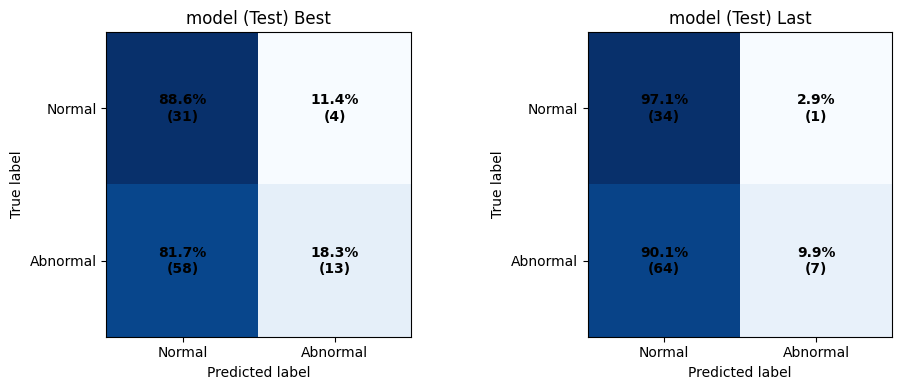

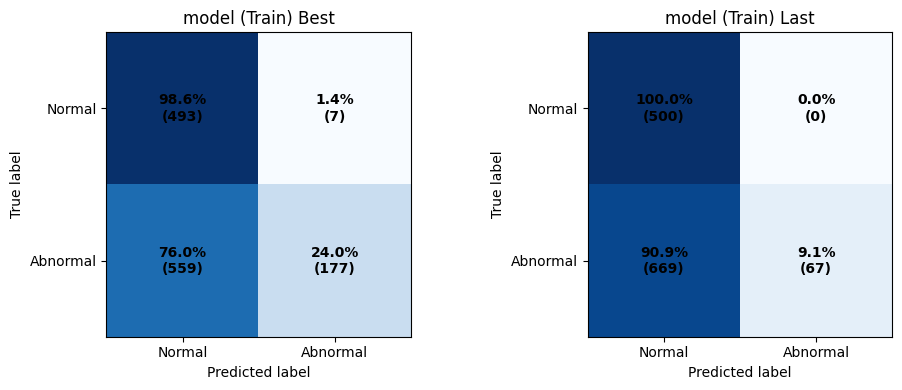

In [45]:
plot_side_by_side_confusions(model_best, model_last, test_loader_pca, "model (Test)")
plot_side_by_side_confusions(model_best, model_last, train_loader_pca, "model (Train)")

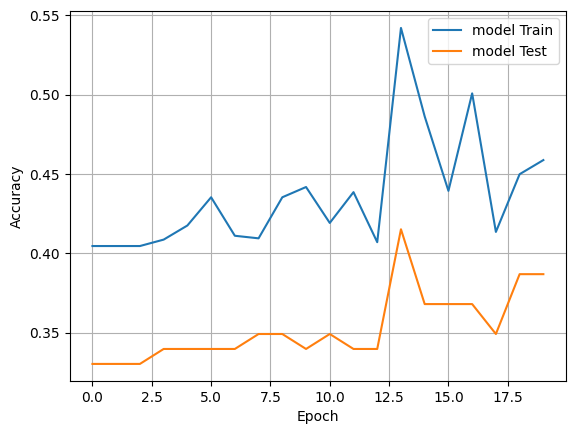

In [46]:
plt.plot(train_acc, label="model Train")
plt.plot(test_acc, label="model Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(which= 'both')
plt.show()

In [ ]:
# # Example: VGG16
# vgg, dim = build_Dinov2B_feature_extractor()
# vgg_train_acc, vgg_test_acc = train_model(
#     vgg, train_loader, test_loader, epochs=10, device="cuda", save_name="Dinov1B"
# )

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


ValueError: optimizer got an empty parameter list

In [ ]:
# vgg_best = build_vgg16()
# vgg_best.load_state_dict(torch.load("vgg16_best.pt"))

# vgg_last = build_vgg16()
# vgg_last.load_state_dict(torch.load("vgg16_last.pt"))

In [ ]:
# plot_side_by_side_confusions(vgg_best, vgg_last, test_loader, "VGG16 (Test)")
# plot_side_by_side_confusions(vgg_best, vgg_last, train_loader, "VGG16 (Test)")

In [ ]:
# plt.plot(vgg_train_acc, label="VGG16 Train")
# plt.plot(vgg_test_acc, label="VGG16 Test")
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
# plt.legend()
# plt.show()

In [ ]:
# resnet = build_resnet152()
# resnet_train_acc, resnet_test_acc = train_model(
#     resnet, train_loader, test_loader, epochs=15, device="cuda", save_name="resnet", lr= 5e-4
# )

In [ ]:
# resnet_best = build_resnet152()
# resnet_best.load_state_dict(torch.load("resnet_best.pt"))

# resnet_last = build_resnet152()
# resnet_last.load_state_dict(torch.load("resnet_last.pt"))


In [ ]:
# plot_side_by_side_confusions(resnet_best, resnet_last, test_loader, "resnet (Test)")
# plot_side_by_side_confusions(resnet_best, resnet_last, train_loader, "resnet (Test)")

In [ ]:

# plt.plot(resnet_train_acc, label="ResNet152 Train")
# plt.plot(resnet_test_acc, label="ResNet152 Test")
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
# plt.legend()
# plt.show()

### Only Extra

In [138]:
# f = lambda epoch: 1 + 30/epochs * (epochs - epoch-1)
# f = lambda x: 100*(1- torch.sigmoid(torch.tensor(0.5 *100/epochs *(x-epochs/2))))
# f = lambda x: 95*(1- torch.sigmoid(torch.tensor(0.2 *100/epochs *(x-epochs/2)))) + 5
# f = lambda x: 200*(1- torch.sigmoid(torch.tensor(0.5 *100/epochs *(x-4*epochs/5)))) + 20
# f = lambda x: 200*(1- torch.sigmoid(torch.tensor(0.5 *100/epochs *(x-4*epochs/5)))) + 60
# f = lambda x: 99*(x<0.9*epochs) + 1
f_wieght = lambda x, y: [2.5, 1]
# f_wieght = lambda x, y: [10*(1- torch.sigmoid(torch.tensor(0.3 *100/y *(x-y/2))))+2, 1]
# f_wieght = lambda x, y: [20*(1- torch.sigmoid(torch.tensor(0.3 *100/y *(x-y/2))))+10, 1]
# f = lambda x, y: 8*(1- torch.sigmoid(torch.tensor(0.3 *100/y *(x-y/2)))) + 3
# f_wieght = lambda x, y: [4*(1- torch.sigmoid(torch.tensor(0.3 *100/y *(x-y/2)))) + 2, 1]
# f_wieght = lambda x, y: [5*(1-torch.sigmoid(torch.tensor(0.3 *100/y *(x-y/2))))+1, 1]
# f_wieght = None

In [139]:
Head = PCAHeadN_res
args = {'input_dim':4,
        'num_classes':2,
        'hidden_dims':[8, 16, 32, 32, 32, 16, 8],
        'dropout':0.3}
model_head = Head(**args).to(device)
criterion = nn.CrossEntropyLoss()
# criterion = nn.CrossEntropyLoss(torch.tensor([10.0, 1]).to(device))
# criterion = BCEWithLogitsLoss()

In [140]:
train_acc, test_acc = train_model(
    model_head, train_loader_pca, test_loader_pca, epochs=40, device="cuda", save_name="model_pca", lr= 1e-4, f_CE_weights= f_wieght)

[Train] Epoch 1/40: 100%|██████████| 78/78 [00:00<00:00, 285.18it/s]


Epoch [1/40] | Train Acc: 0.5955 | Test Acc: 0.6698


[Train] Epoch 2/40: 100%|██████████| 78/78 [00:00<00:00, 233.23it/s]


Epoch [2/40] | Train Acc: 0.5955 | Test Acc: 0.6698


[Train] Epoch 3/40: 100%|██████████| 78/78 [00:00<00:00, 253.13it/s]


Epoch [3/40] | Train Acc: 0.5955 | Test Acc: 0.6698


[Train] Epoch 4/40: 100%|██████████| 78/78 [00:00<00:00, 214.98it/s]


Epoch [4/40] | Train Acc: 0.5955 | Test Acc: 0.6698


[Train] Epoch 5/40: 100%|██████████| 78/78 [00:00<00:00, 234.52it/s]


Epoch [5/40] | Train Acc: 0.5955 | Test Acc: 0.6698


[Train] Epoch 6/40: 100%|██████████| 78/78 [00:00<00:00, 240.95it/s]


Epoch [6/40] | Train Acc: 0.5955 | Test Acc: 0.6698


[Train] Epoch 7/40: 100%|██████████| 78/78 [00:00<00:00, 216.16it/s]


Epoch [7/40] | Train Acc: 0.5955 | Test Acc: 0.6698


[Train] Epoch 8/40: 100%|██████████| 78/78 [00:00<00:00, 280.41it/s]


Epoch [8/40] | Train Acc: 0.5955 | Test Acc: 0.6698


[Train] Epoch 9/40: 100%|██████████| 78/78 [00:00<00:00, 309.69it/s]


Epoch [9/40] | Train Acc: 0.5955 | Test Acc: 0.6698


[Train] Epoch 10/40: 100%|██████████| 78/78 [00:00<00:00, 283.61it/s]


Epoch [10/40] | Train Acc: 0.4595 | Test Acc: 0.3868


[Train] Epoch 11/40: 100%|██████████| 78/78 [00:00<00:00, 289.62it/s]


Epoch [11/40] | Train Acc: 0.4045 | Test Acc: 0.3302


[Train] Epoch 12/40: 100%|██████████| 78/78 [00:00<00:00, 295.23it/s]


Epoch [12/40] | Train Acc: 0.4045 | Test Acc: 0.3302


[Train] Epoch 13/40: 100%|██████████| 78/78 [00:00<00:00, 299.42it/s]


Epoch [13/40] | Train Acc: 0.4045 | Test Acc: 0.3302


[Train] Epoch 14/40: 100%|██████████| 78/78 [00:00<00:00, 304.77it/s]


Epoch [14/40] | Train Acc: 0.4045 | Test Acc: 0.3302


[Train] Epoch 15/40: 100%|██████████| 78/78 [00:00<00:00, 313.49it/s]


Epoch [15/40] | Train Acc: 0.4045 | Test Acc: 0.3302


[Train] Epoch 16/40: 100%|██████████| 78/78 [00:00<00:00, 290.71it/s]


Epoch [16/40] | Train Acc: 0.4045 | Test Acc: 0.3302


[Train] Epoch 17/40: 100%|██████████| 78/78 [00:00<00:00, 309.77it/s]


Epoch [17/40] | Train Acc: 0.4045 | Test Acc: 0.3302


[Train] Epoch 18/40: 100%|██████████| 78/78 [00:00<00:00, 313.87it/s]


Epoch [18/40] | Train Acc: 0.4045 | Test Acc: 0.3302


[Train] Epoch 19/40: 100%|██████████| 78/78 [00:00<00:00, 294.37it/s]


Epoch [19/40] | Train Acc: 0.4045 | Test Acc: 0.3302


[Train] Epoch 20/40: 100%|██████████| 78/78 [00:00<00:00, 313.05it/s]


Epoch [20/40] | Train Acc: 0.4045 | Test Acc: 0.3302


[Train] Epoch 21/40: 100%|██████████| 78/78 [00:00<00:00, 306.28it/s]


Epoch [21/40] | Train Acc: 0.4045 | Test Acc: 0.3302


[Train] Epoch 22/40: 100%|██████████| 78/78 [00:00<00:00, 289.94it/s]


Epoch [22/40] | Train Acc: 0.4045 | Test Acc: 0.3302


[Train] Epoch 23/40: 100%|██████████| 78/78 [00:00<00:00, 308.78it/s]


Epoch [23/40] | Train Acc: 0.4045 | Test Acc: 0.3302


[Train] Epoch 24/40: 100%|██████████| 78/78 [00:00<00:00, 304.40it/s]


Epoch [24/40] | Train Acc: 0.4045 | Test Acc: 0.3302


[Train] Epoch 25/40: 100%|██████████| 78/78 [00:00<00:00, 293.59it/s]


Epoch [25/40] | Train Acc: 0.4045 | Test Acc: 0.3302


[Train] Epoch 26/40: 100%|██████████| 78/78 [00:00<00:00, 297.78it/s]


Epoch [26/40] | Train Acc: 0.4045 | Test Acc: 0.3302


[Train] Epoch 27/40: 100%|██████████| 78/78 [00:00<00:00, 299.45it/s]


Epoch [27/40] | Train Acc: 0.4045 | Test Acc: 0.3302


[Train] Epoch 28/40: 100%|██████████| 78/78 [00:00<00:00, 283.87it/s]


Epoch [28/40] | Train Acc: 0.4045 | Test Acc: 0.3302


[Train] Epoch 29/40: 100%|██████████| 78/78 [00:00<00:00, 299.26it/s]


Epoch [29/40] | Train Acc: 0.4045 | Test Acc: 0.3302


[Train] Epoch 30/40: 100%|██████████| 78/78 [00:00<00:00, 301.01it/s]


Epoch [30/40] | Train Acc: 0.4045 | Test Acc: 0.3302


[Train] Epoch 31/40: 100%|██████████| 78/78 [00:00<00:00, 297.34it/s]


Epoch [31/40] | Train Acc: 0.4045 | Test Acc: 0.3302


[Train] Epoch 32/40: 100%|██████████| 78/78 [00:00<00:00, 303.41it/s]


Epoch [32/40] | Train Acc: 0.4045 | Test Acc: 0.3302


[Train] Epoch 33/40: 100%|██████████| 78/78 [00:00<00:00, 304.90it/s]


Epoch [33/40] | Train Acc: 0.4045 | Test Acc: 0.3302


[Train] Epoch 34/40: 100%|██████████| 78/78 [00:00<00:00, 300.16it/s]


Epoch [34/40] | Train Acc: 0.4045 | Test Acc: 0.3302


[Train] Epoch 35/40: 100%|██████████| 78/78 [00:00<00:00, 302.93it/s]


Epoch [35/40] | Train Acc: 0.4045 | Test Acc: 0.3302


[Train] Epoch 36/40: 100%|██████████| 78/78 [00:00<00:00, 296.30it/s]


Epoch [36/40] | Train Acc: 0.4045 | Test Acc: 0.3302


[Train] Epoch 37/40: 100%|██████████| 78/78 [00:00<00:00, 221.60it/s]


Epoch [37/40] | Train Acc: 0.4045 | Test Acc: 0.3302


[Train] Epoch 38/40: 100%|██████████| 78/78 [00:00<00:00, 241.16it/s]


Epoch [38/40] | Train Acc: 0.4045 | Test Acc: 0.3302


[Train] Epoch 39/40: 100%|██████████| 78/78 [00:00<00:00, 203.43it/s]


Epoch [39/40] | Train Acc: 0.4045 | Test Acc: 0.3302


[Train] Epoch 40/40: 100%|██████████| 78/78 [00:00<00:00, 228.88it/s]


Epoch [40/40] | Train Acc: 0.4045 | Test Acc: 0.3302
✅ Best Test Accuracy: 0.6698


In [141]:
model_best = Head(**args).to("cuda")
model_best.load_state_dict(torch.load("model_pca_best.pt"))

model_last = Head(**args).to("cuda")
model_last.load_state_dict(torch.load("model_pca_last.pt"))

<All keys matched successfully>

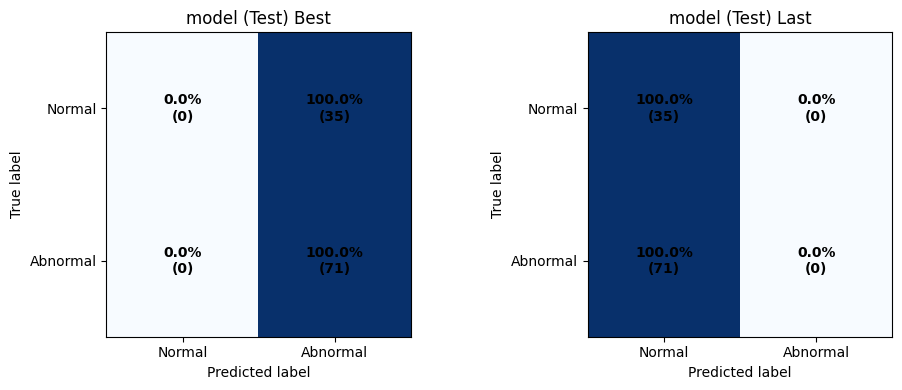

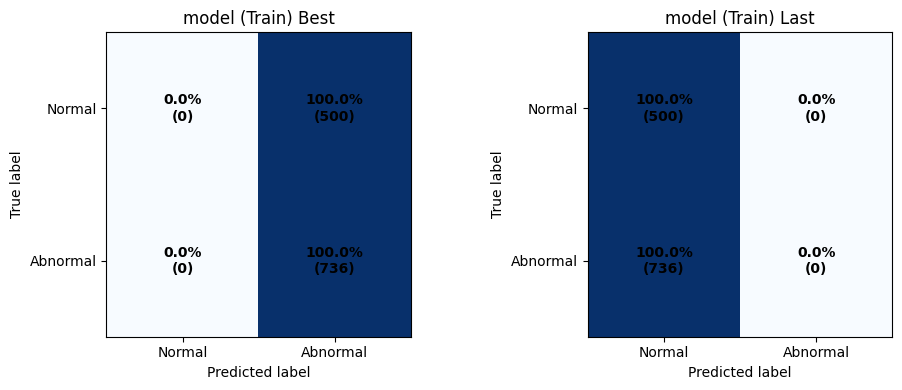

In [142]:
plot_side_by_side_confusions(model_best, model_last, test_loader_pca, "model (Test)")
plot_side_by_side_confusions(model_best, model_last, train_loader_pca, "model (Train)")

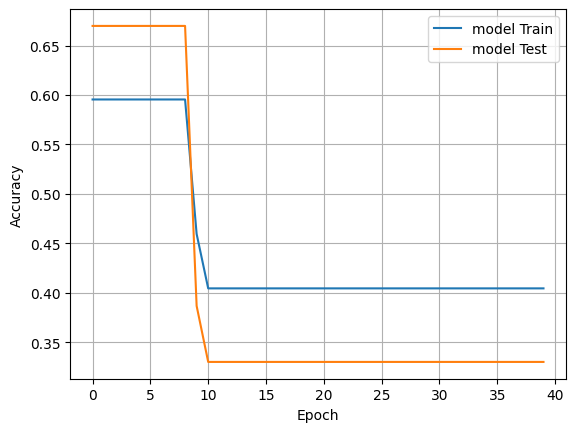

In [143]:
plt.plot(train_acc, label="model Train")
plt.plot(test_acc, label="model Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(which= 'both')
plt.show()

### train PCA models

In [98]:
# f = lambda epoch: 1 + 30/epochs * (epochs - epoch-1)
# f = lambda x: 100*(1- torch.sigmoid(torch.tensor(0.5 *100/epochs *(x-epochs/2))))
# f = lambda x: 95*(1- torch.sigmoid(torch.tensor(0.2 *100/epochs *(x-epochs/2)))) + 5
# f = lambda x: 200*(1- torch.sigmoid(torch.tensor(0.5 *100/epochs *(x-4*epochs/5)))) + 20
# f = lambda x: 200*(1- torch.sigmoid(torch.tensor(0.5 *100/epochs *(x-4*epochs/5)))) + 60
# f = lambda x: 99*(x<0.9*epochs) + 1
f_wieght = lambda x, y: [2.5, 1]
# f_wieght = lambda x, y:[10*(1- torch.sigmoid(torch.tensor(0.3 *100/y *(x-y/2))))+2, 1]
# f_wieght = lambda x, y: [20*(1- torch.sigmoid(torch.tensor(0.3 *100/y *(x-y/2))))+10, 1]
# f = lambda x, y: 8*(1- torch.sigmoid(torch.tensor(0.3 *100/y *(x-y/2)))) + 3
# f_wieght = lambda x, y: [4*(1- torch.sigmoid(torch.tensor(0.3 *100/y *(x-y/2)))) + 2, 1]
# f_wieght = lambda x, y: [5*(1-torch.sigmoid(torch.tensor(0.3 *100/y *(x-y/2))))+1.5, 1]
# f_wieght = None

In [106]:
Head = MultiModalClassifier
args = {'img_dim': train_pca.shape[1],
        'tab_dim': 4,                # number of tabular features
        'tab_hidden': [16, 32],      # adapter sizes
        'head_hidden': [64, 32],    # classifier hidden layers
        'num_classes': 2,
        'dropout': 0.3}
model_head = Head(**args).to(device)
criterion = nn.CrossEntropyLoss()
# criterion = nn.CrossEntropyLoss(torch.tensor([10.0, 1]).to(device))
# criterion = BCEWithLogitsLoss()

In [107]:
train_acc, test_acc = train_model(
    model_head, train_loader_pca, test_loader_pca, epochs=100, device="cuda", save_name="model_pca", lr= 1e-4, f_CE_weights= f_wieght)

[Train] Epoch 1/100: 100%|██████████| 78/78 [00:00<00:00, 188.28it/s]


Epoch [1/100] | Train Acc: 0.4070 | Test Acc: 0.3302


[Train] Epoch 2/100: 100%|██████████| 78/78 [00:00<00:00, 217.96it/s]


Epoch [2/100] | Train Acc: 0.4045 | Test Acc: 0.3302


[Train] Epoch 3/100: 100%|██████████| 78/78 [00:00<00:00, 241.01it/s]


Epoch [3/100] | Train Acc: 0.4045 | Test Acc: 0.3302


[Train] Epoch 4/100: 100%|██████████| 78/78 [00:00<00:00, 223.53it/s]


Epoch [4/100] | Train Acc: 0.4045 | Test Acc: 0.3302


[Train] Epoch 5/100: 100%|██████████| 78/78 [00:00<00:00, 192.29it/s]


Epoch [5/100] | Train Acc: 0.4045 | Test Acc: 0.3302


[Train] Epoch 6/100: 100%|██████████| 78/78 [00:00<00:00, 243.39it/s]


Epoch [6/100] | Train Acc: 0.4045 | Test Acc: 0.3302


[Train] Epoch 7/100: 100%|██████████| 78/78 [00:00<00:00, 153.39it/s]


Epoch [7/100] | Train Acc: 0.4045 | Test Acc: 0.3302


[Train] Epoch 8/100: 100%|██████████| 78/78 [00:00<00:00, 218.51it/s]


Epoch [8/100] | Train Acc: 0.4045 | Test Acc: 0.3302


[Train] Epoch 9/100: 100%|██████████| 78/78 [00:00<00:00, 154.79it/s]


Epoch [9/100] | Train Acc: 0.4070 | Test Acc: 0.3302


[Train] Epoch 10/100: 100%|██████████| 78/78 [00:00<00:00, 168.05it/s]


Epoch [10/100] | Train Acc: 0.4126 | Test Acc: 0.3302


[Train] Epoch 11/100: 100%|██████████| 78/78 [00:00<00:00, 132.14it/s]


Epoch [11/100] | Train Acc: 0.4353 | Test Acc: 0.3302


[Train] Epoch 12/100: 100%|██████████| 78/78 [00:00<00:00, 151.80it/s]


Epoch [12/100] | Train Acc: 0.4709 | Test Acc: 0.3585


[Train] Epoch 13/100: 100%|██████████| 78/78 [00:00<00:00, 149.34it/s]


Epoch [13/100] | Train Acc: 0.5469 | Test Acc: 0.4057


[Train] Epoch 14/100: 100%|██████████| 78/78 [00:00<00:00, 166.44it/s]


Epoch [14/100] | Train Acc: 0.6157 | Test Acc: 0.4434


[Train] Epoch 15/100: 100%|██████████| 78/78 [00:00<00:00, 215.03it/s]


Epoch [15/100] | Train Acc: 0.6885 | Test Acc: 0.4717


[Train] Epoch 16/100: 100%|██████████| 78/78 [00:00<00:00, 170.17it/s]


Epoch [16/100] | Train Acc: 0.7330 | Test Acc: 0.5000


[Train] Epoch 17/100: 100%|██████████| 78/78 [00:00<00:00, 218.26it/s]


Epoch [17/100] | Train Acc: 0.7646 | Test Acc: 0.5094


[Train] Epoch 18/100: 100%|██████████| 78/78 [00:00<00:00, 220.52it/s]


Epoch [18/100] | Train Acc: 0.7816 | Test Acc: 0.5472


[Train] Epoch 19/100: 100%|██████████| 78/78 [00:00<00:00, 252.36it/s]


Epoch [19/100] | Train Acc: 0.7945 | Test Acc: 0.5472


[Train] Epoch 20/100: 100%|██████████| 78/78 [00:00<00:00, 216.12it/s]


Epoch [20/100] | Train Acc: 0.8083 | Test Acc: 0.5472


[Train] Epoch 21/100: 100%|██████████| 78/78 [00:00<00:00, 212.44it/s]


Epoch [21/100] | Train Acc: 0.8196 | Test Acc: 0.5283


[Train] Epoch 22/100: 100%|██████████| 78/78 [00:00<00:00, 256.35it/s]


Epoch [22/100] | Train Acc: 0.8301 | Test Acc: 0.5566


[Train] Epoch 23/100: 100%|██████████| 78/78 [00:00<00:00, 227.94it/s]


Epoch [23/100] | Train Acc: 0.8479 | Test Acc: 0.5755


[Train] Epoch 24/100: 100%|██████████| 78/78 [00:00<00:00, 250.41it/s]


Epoch [24/100] | Train Acc: 0.8511 | Test Acc: 0.5755


[Train] Epoch 25/100: 100%|██████████| 78/78 [00:00<00:00, 200.84it/s]


Epoch [25/100] | Train Acc: 0.8576 | Test Acc: 0.5755


[Train] Epoch 26/100: 100%|██████████| 78/78 [00:00<00:00, 257.46it/s]


Epoch [26/100] | Train Acc: 0.8617 | Test Acc: 0.5849


[Train] Epoch 27/100: 100%|██████████| 78/78 [00:00<00:00, 229.09it/s]


Epoch [27/100] | Train Acc: 0.8746 | Test Acc: 0.5755


[Train] Epoch 28/100: 100%|██████████| 78/78 [00:00<00:00, 209.69it/s]


Epoch [28/100] | Train Acc: 0.8811 | Test Acc: 0.5943


[Train] Epoch 29/100: 100%|██████████| 78/78 [00:00<00:00, 136.04it/s]


Epoch [29/100] | Train Acc: 0.8867 | Test Acc: 0.6038


[Train] Epoch 30/100: 100%|██████████| 78/78 [00:00<00:00, 232.59it/s]


Epoch [30/100] | Train Acc: 0.8916 | Test Acc: 0.6038


[Train] Epoch 31/100: 100%|██████████| 78/78 [00:00<00:00, 228.44it/s]


Epoch [31/100] | Train Acc: 0.8948 | Test Acc: 0.6038


[Train] Epoch 32/100: 100%|██████████| 78/78 [00:00<00:00, 227.81it/s]


Epoch [32/100] | Train Acc: 0.9013 | Test Acc: 0.6038


[Train] Epoch 33/100: 100%|██████████| 78/78 [00:00<00:00, 220.21it/s]


Epoch [33/100] | Train Acc: 0.9021 | Test Acc: 0.6038


[Train] Epoch 34/100: 100%|██████████| 78/78 [00:00<00:00, 408.31it/s]


Epoch [34/100] | Train Acc: 0.9159 | Test Acc: 0.6038


[Train] Epoch 35/100: 100%|██████████| 78/78 [00:00<00:00, 419.55it/s]


Epoch [35/100] | Train Acc: 0.9223 | Test Acc: 0.6226


[Train] Epoch 36/100: 100%|██████████| 78/78 [00:00<00:00, 401.99it/s]


Epoch [36/100] | Train Acc: 0.9272 | Test Acc: 0.6132


[Train] Epoch 37/100: 100%|██████████| 78/78 [00:00<00:00, 378.48it/s]


Epoch [37/100] | Train Acc: 0.9272 | Test Acc: 0.6132


[Train] Epoch 38/100: 100%|██████████| 78/78 [00:00<00:00, 295.35it/s]


Epoch [38/100] | Train Acc: 0.9361 | Test Acc: 0.6226


[Train] Epoch 39/100: 100%|██████████| 78/78 [00:00<00:00, 322.43it/s]


Epoch [39/100] | Train Acc: 0.9417 | Test Acc: 0.6226


[Train] Epoch 40/100: 100%|██████████| 78/78 [00:00<00:00, 321.56it/s]


Epoch [40/100] | Train Acc: 0.9547 | Test Acc: 0.6226


[Train] Epoch 41/100: 100%|██████████| 78/78 [00:00<00:00, 290.02it/s]


Epoch [41/100] | Train Acc: 0.9539 | Test Acc: 0.6226


[Train] Epoch 42/100: 100%|██████████| 78/78 [00:00<00:00, 323.32it/s]


Epoch [42/100] | Train Acc: 0.9579 | Test Acc: 0.6321


[Train] Epoch 43/100: 100%|██████████| 78/78 [00:00<00:00, 312.99it/s]


Epoch [43/100] | Train Acc: 0.9579 | Test Acc: 0.6321


[Train] Epoch 44/100: 100%|██████████| 78/78 [00:00<00:00, 344.80it/s]


Epoch [44/100] | Train Acc: 0.9644 | Test Acc: 0.6321


[Train] Epoch 45/100: 100%|██████████| 78/78 [00:00<00:00, 288.77it/s]


Epoch [45/100] | Train Acc: 0.9644 | Test Acc: 0.6321


[Train] Epoch 46/100: 100%|██████████| 78/78 [00:00<00:00, 272.32it/s]


Epoch [46/100] | Train Acc: 0.9660 | Test Acc: 0.6321


[Train] Epoch 47/100: 100%|██████████| 78/78 [00:00<00:00, 426.35it/s]


Epoch [47/100] | Train Acc: 0.9701 | Test Acc: 0.6321


[Train] Epoch 48/100: 100%|██████████| 78/78 [00:00<00:00, 419.65it/s]


Epoch [48/100] | Train Acc: 0.9709 | Test Acc: 0.6321


[Train] Epoch 49/100: 100%|██████████| 78/78 [00:00<00:00, 426.89it/s]


Epoch [49/100] | Train Acc: 0.9725 | Test Acc: 0.6321


[Train] Epoch 50/100: 100%|██████████| 78/78 [00:00<00:00, 397.72it/s]


Epoch [50/100] | Train Acc: 0.9733 | Test Acc: 0.6415


[Train] Epoch 51/100: 100%|██████████| 78/78 [00:00<00:00, 420.09it/s]


Epoch [51/100] | Train Acc: 0.9741 | Test Acc: 0.6415


[Train] Epoch 52/100: 100%|██████████| 78/78 [00:00<00:00, 414.66it/s]


Epoch [52/100] | Train Acc: 0.9765 | Test Acc: 0.6415


[Train] Epoch 53/100: 100%|██████████| 78/78 [00:00<00:00, 415.56it/s]


Epoch [53/100] | Train Acc: 0.9822 | Test Acc: 0.6415


[Train] Epoch 54/100: 100%|██████████| 78/78 [00:00<00:00, 406.98it/s]


Epoch [54/100] | Train Acc: 0.9822 | Test Acc: 0.6415


[Train] Epoch 55/100: 100%|██████████| 78/78 [00:00<00:00, 420.13it/s]


Epoch [55/100] | Train Acc: 0.9846 | Test Acc: 0.6321


[Train] Epoch 56/100: 100%|██████████| 78/78 [00:00<00:00, 405.24it/s]


Epoch [56/100] | Train Acc: 0.9846 | Test Acc: 0.6321


[Train] Epoch 57/100: 100%|██████████| 78/78 [00:00<00:00, 411.10it/s]


Epoch [57/100] | Train Acc: 0.9854 | Test Acc: 0.6321


[Train] Epoch 58/100: 100%|██████████| 78/78 [00:00<00:00, 417.41it/s]


Epoch [58/100] | Train Acc: 0.9887 | Test Acc: 0.6321


[Train] Epoch 59/100: 100%|██████████| 78/78 [00:00<00:00, 423.87it/s]


Epoch [59/100] | Train Acc: 0.9871 | Test Acc: 0.6321


[Train] Epoch 60/100: 100%|██████████| 78/78 [00:00<00:00, 422.25it/s]


Epoch [60/100] | Train Acc: 0.9895 | Test Acc: 0.6415


[Train] Epoch 61/100: 100%|██████████| 78/78 [00:00<00:00, 425.06it/s]


Epoch [61/100] | Train Acc: 0.9943 | Test Acc: 0.6226


[Train] Epoch 62/100: 100%|██████████| 78/78 [00:00<00:00, 372.75it/s]


Epoch [62/100] | Train Acc: 0.9911 | Test Acc: 0.6132


[Train] Epoch 63/100: 100%|██████████| 78/78 [00:00<00:00, 407.21it/s]


Epoch [63/100] | Train Acc: 0.9919 | Test Acc: 0.6226


[Train] Epoch 64/100: 100%|██████████| 78/78 [00:00<00:00, 401.61it/s]


Epoch [64/100] | Train Acc: 0.9951 | Test Acc: 0.6415


[Train] Epoch 65/100: 100%|██████████| 78/78 [00:00<00:00, 397.43it/s]


Epoch [65/100] | Train Acc: 0.9960 | Test Acc: 0.6321


[Train] Epoch 66/100: 100%|██████████| 78/78 [00:00<00:00, 396.25it/s]


Epoch [66/100] | Train Acc: 0.9951 | Test Acc: 0.6321


[Train] Epoch 67/100: 100%|██████████| 78/78 [00:00<00:00, 415.94it/s]


Epoch [67/100] | Train Acc: 0.9960 | Test Acc: 0.6321


[Train] Epoch 68/100: 100%|██████████| 78/78 [00:00<00:00, 418.98it/s]


Epoch [68/100] | Train Acc: 0.9968 | Test Acc: 0.6415


[Train] Epoch 69/100: 100%|██████████| 78/78 [00:00<00:00, 396.54it/s]


Epoch [69/100] | Train Acc: 0.9976 | Test Acc: 0.6415


[Train] Epoch 70/100: 100%|██████████| 78/78 [00:00<00:00, 402.02it/s]


Epoch [70/100] | Train Acc: 0.9968 | Test Acc: 0.6226


[Train] Epoch 71/100: 100%|██████████| 78/78 [00:00<00:00, 421.06it/s]


Epoch [71/100] | Train Acc: 0.9976 | Test Acc: 0.6321


[Train] Epoch 72/100: 100%|██████████| 78/78 [00:00<00:00, 414.73it/s]


Epoch [72/100] | Train Acc: 0.9968 | Test Acc: 0.6321


[Train] Epoch 73/100: 100%|██████████| 78/78 [00:00<00:00, 394.01it/s]


Epoch [73/100] | Train Acc: 0.9984 | Test Acc: 0.6321


[Train] Epoch 74/100: 100%|██████████| 78/78 [00:00<00:00, 412.99it/s]


Epoch [74/100] | Train Acc: 0.9984 | Test Acc: 0.6226


[Train] Epoch 75/100: 100%|██████████| 78/78 [00:00<00:00, 416.74it/s]


Epoch [75/100] | Train Acc: 0.9984 | Test Acc: 0.6226


[Train] Epoch 76/100: 100%|██████████| 78/78 [00:00<00:00, 413.92it/s]


Epoch [76/100] | Train Acc: 0.9984 | Test Acc: 0.6321


[Train] Epoch 77/100: 100%|██████████| 78/78 [00:00<00:00, 396.66it/s]


Epoch [77/100] | Train Acc: 0.9984 | Test Acc: 0.6226


[Train] Epoch 78/100: 100%|██████████| 78/78 [00:00<00:00, 413.11it/s]


Epoch [78/100] | Train Acc: 0.9992 | Test Acc: 0.6226


[Train] Epoch 79/100: 100%|██████████| 78/78 [00:00<00:00, 420.81it/s]


Epoch [79/100] | Train Acc: 0.9992 | Test Acc: 0.6226


[Train] Epoch 80/100: 100%|██████████| 78/78 [00:00<00:00, 422.14it/s]


Epoch [80/100] | Train Acc: 1.0000 | Test Acc: 0.6226


[Train] Epoch 81/100: 100%|██████████| 78/78 [00:00<00:00, 398.23it/s]


Epoch [81/100] | Train Acc: 0.9992 | Test Acc: 0.6321


[Train] Epoch 82/100: 100%|██████████| 78/78 [00:00<00:00, 408.50it/s]


Epoch [82/100] | Train Acc: 1.0000 | Test Acc: 0.6226


[Train] Epoch 83/100: 100%|██████████| 78/78 [00:00<00:00, 407.55it/s]


Epoch [83/100] | Train Acc: 1.0000 | Test Acc: 0.6321


[Train] Epoch 84/100: 100%|██████████| 78/78 [00:00<00:00, 379.31it/s]


Epoch [84/100] | Train Acc: 1.0000 | Test Acc: 0.6226


[Train] Epoch 85/100: 100%|██████████| 78/78 [00:00<00:00, 302.32it/s]


Epoch [85/100] | Train Acc: 1.0000 | Test Acc: 0.6321


[Train] Epoch 86/100: 100%|██████████| 78/78 [00:00<00:00, 328.95it/s]


Epoch [86/100] | Train Acc: 1.0000 | Test Acc: 0.6415


[Train] Epoch 87/100: 100%|██████████| 78/78 [00:00<00:00, 344.69it/s]


Epoch [87/100] | Train Acc: 1.0000 | Test Acc: 0.6415


[Train] Epoch 88/100: 100%|██████████| 78/78 [00:00<00:00, 303.25it/s]


Epoch [88/100] | Train Acc: 1.0000 | Test Acc: 0.6415


[Train] Epoch 89/100: 100%|██████████| 78/78 [00:00<00:00, 342.75it/s]


Epoch [89/100] | Train Acc: 1.0000 | Test Acc: 0.6415


[Train] Epoch 90/100: 100%|██████████| 78/78 [00:00<00:00, 337.05it/s]


Epoch [90/100] | Train Acc: 1.0000 | Test Acc: 0.6415


[Train] Epoch 91/100: 100%|██████████| 78/78 [00:00<00:00, 319.92it/s]


Epoch [91/100] | Train Acc: 1.0000 | Test Acc: 0.6415


[Train] Epoch 92/100: 100%|██████████| 78/78 [00:00<00:00, 286.02it/s]


Epoch [92/100] | Train Acc: 1.0000 | Test Acc: 0.6415


[Train] Epoch 93/100: 100%|██████████| 78/78 [00:00<00:00, 278.73it/s]


Epoch [93/100] | Train Acc: 1.0000 | Test Acc: 0.6321


[Train] Epoch 94/100: 100%|██████████| 78/78 [00:00<00:00, 378.82it/s]


Epoch [94/100] | Train Acc: 1.0000 | Test Acc: 0.6415


[Train] Epoch 95/100: 100%|██████████| 78/78 [00:00<00:00, 409.17it/s]


Epoch [95/100] | Train Acc: 1.0000 | Test Acc: 0.6132


[Train] Epoch 96/100: 100%|██████████| 78/78 [00:00<00:00, 416.93it/s]


Epoch [96/100] | Train Acc: 1.0000 | Test Acc: 0.6226


[Train] Epoch 97/100: 100%|██████████| 78/78 [00:00<00:00, 423.52it/s]


Epoch [97/100] | Train Acc: 1.0000 | Test Acc: 0.6132


[Train] Epoch 98/100: 100%|██████████| 78/78 [00:00<00:00, 397.10it/s]


Epoch [98/100] | Train Acc: 1.0000 | Test Acc: 0.6415


[Train] Epoch 99/100: 100%|██████████| 78/78 [00:00<00:00, 415.23it/s]


Epoch [99/100] | Train Acc: 1.0000 | Test Acc: 0.6415


[Train] Epoch 100/100: 100%|██████████| 78/78 [00:00<00:00, 416.07it/s]


Epoch [100/100] | Train Acc: 1.0000 | Test Acc: 0.6226
✅ Best Test Accuracy: 0.6415


In [108]:
model_best = Head(**args).to("cuda")
model_best.load_state_dict(torch.load("model_pca_best.pt"))

model_last = Head(**args).to("cuda")
model_last.load_state_dict(torch.load("model_pca_last.pt"))

<All keys matched successfully>

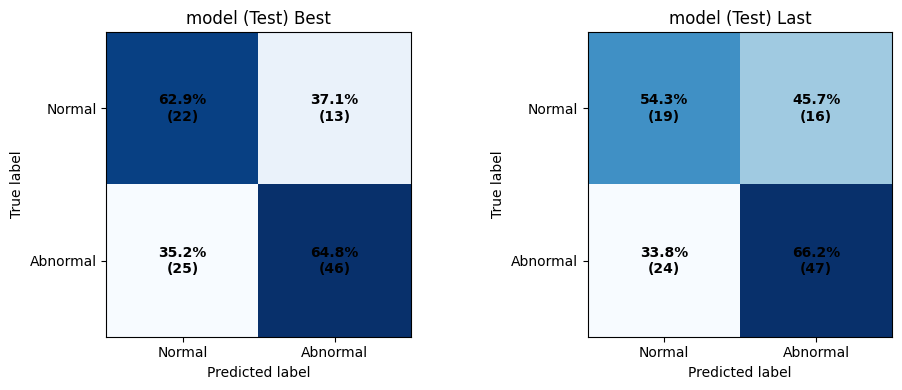

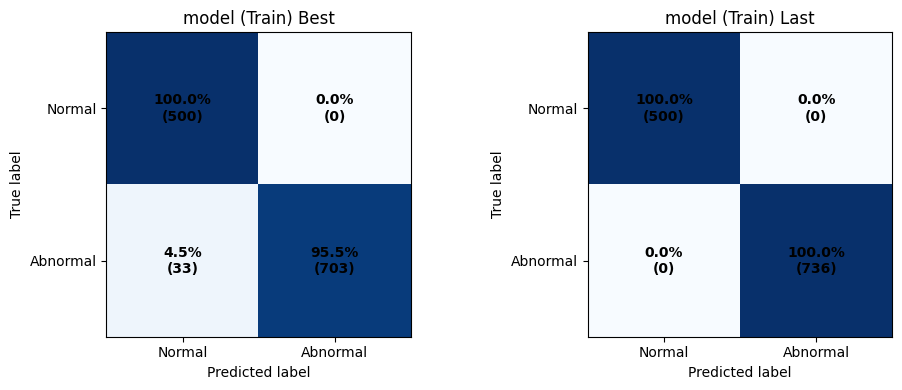

In [109]:
plot_side_by_side_confusions(model_best, model_last, test_loader_pca, "model (Test)")
plot_side_by_side_confusions(model_best, model_last, train_loader_pca, "model (Train)")

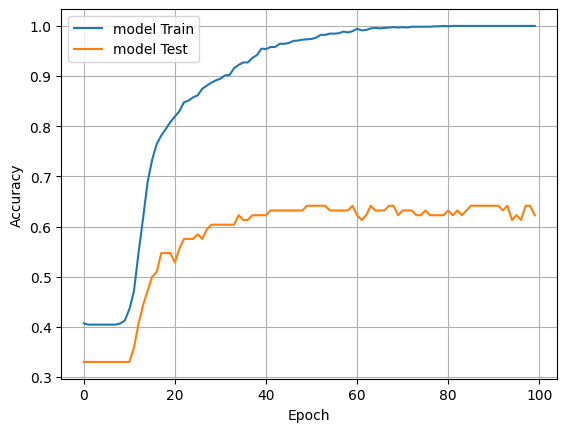

In [110]:


plt.plot(train_acc, label="model Train")
plt.plot(test_acc, label="model Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(which= 'both')
plt.show()

### Train PCA based model

In [ ]:
pca_matrix = torch.tensor(pca.components_, dtype=torch.float32)

class PCARegularizedModel(nn.Module):
    def __init__(self, input_dim, pca_dim, num_classes, pca_matrix):
        super().__init__()

        # Learnable projection initialized randomly
        self.proj = nn.Linear(input_dim, pca_dim, bias=False)

        # PCA matrix from sklearn (frozen)
        self.pca_matrix = nn.Parameter(pca_matrix.clone(), requires_grad=False)

        self.proj.weight.data = pca_matrix.clone()

        self.classifier = nn.Linear(pca_dim, num_classes)

    def forward(self, feats):
        z = self.proj(feats)
        return self.classifier(z)

    def regularization_loss(self):
        return F.mse_loss(self.proj.weight, self.pca_matrix)


class PCARegularizedModel_LoRA(nn.Module):
    def __init__(self, input_dim, pca_dim, LoRA_dim, num_classes, pca_matrix):
        super().__init__()

        # Learnable projection initialized randomly
        self.LoRA_fc1 = nn.Linear(input_dim, LoRA_dim, bias=False)
        self.LoRa_fc2 = nn.Linear(LoRA_dim, pca_dim, bias=False)

        # PCA matrix from sklearn (frozen)
        self.pca_matrix = nn.Parameter(pca_matrix.clone(), requires_grad=False)

        self.classifier = nn.Linear(pca_dim, num_classes)

    def forward(self, feats):
        # PCA projection
        z_pca = feats @ self.pca_matrix.T   # (B, pca_dim)
        # LoRA residual ΔW x = B(A(x))
        z_lora = self.LoRa_fc2(self.LoRA_fc1(feats))
        # Combine
        z = z_pca + z_lora
        return self.classifier(z)


class Combined_loss(nn.Module):
    def __init__(self, model, coef=0.01, weight = None):
        super().__init__()
        self.model = model
        self.coef = coef
        self.ce_loss = nn.CrossEntropyLoss()
        self.weight = weight

    def forward(self, outputs, labels):
        if self.weight is not None:
            self.ce_loss.weight = self.weight.to(device)
        ce = self.ce_loss(outputs, labels)
        reg = self.model.regularization_loss()
        print(ce, reg)
        return ce + self.coef * reg

In [ ]:
# train_dataset_feats = Bsaic_Dataset(train_feats, train_labels)
# test_dataset_feats = Bsaic_Dataset(test_feats, test_labels)

# train_loader_feats = DataLoader(train_dataset_feats, batch_size=16, shuffle=True, num_workers=0)
# test_loader_feats  = DataLoader(test_dataset_feats, batch_size=32, shuffle=False, num_workers=0)

In [ ]:
# args = {"input_dim": train_feats.shape[1], "pca_dim": pca_dim, "num_classes": 2, "pca_matrix": pca_matrix, "LoRA_dim": 4}
# # args = {"input_dim": train_feats.shape[1], "pca_dim": pca_dim, "num_classes": 2, "pca_matrix": pca_matrix}
# Head_class = PCARegularizedModel_LoRA
# model = Head_class(**args)
# # criterion = Combined_loss(model, coef=500)
# criterion = nn.CrossEntropyLoss()
# # criterion = nn.BCELoss()
# # criterion = nn.BCEWithLogitsLoss()


In [ ]:
    # f = lambda epoch: 1 + 30/epochs * (epochs - epoch-1)
    # f = lambda x: 100*(1- torch.sigmoid(torch.tensor(0.5 *100/epochs *(x-epochs/2))))
    # f = lambda x: 95*(1- torch.sigmoid(torch.tensor(0.2 *100/epochs *(x-epochs/2)))) + 5
    # f = lambda x: 200*(1- torch.sigmoid(torch.tensor(0.5 *100/epochs *(x-4*epochs/5)))) + 20
    # f = lambda x: 200*(1- torch.sigmoid(torch.tensor(0.5 *100/epochs *(x-4*epochs/5)))) + 60
    # f = lambda x: 99*(x<0.9*epochs) + 1
    # f = lambda x: 10
    # f = lambda x, y: 10*(1- torch.sigmoid(torch.tensor(0.3 *100/y *(x-y/2))))
    # f = lambda x, y: 8*(1- torch.sigmoid(torch.tensor(0.3 *100/y *(x-y/2)))) + 3
    # f = lambda x: None


In [ ]:
# train_acc, test_acc = train_model(
#     model, train_loader_feats, test_loader_feats, epochs=150, device="cuda", save_name="model_pca_reg", lr= 5e-5, f_CE_weights= f)

In [ ]:
# model_best = Head_class(**args)
# model_best.load_state_dict(torch.load("model_pca_reg_best.pt"))

# model_last = Head_class(**args)
# model_last.load_state_dict(torch.load("model_pca_reg_last.pt"))

In [ ]:
# plot_side_by_side_confusions(model_best, model_last, test_loader_feats, "model (Test)")
# plot_side_by_side_confusions(model_best, model_last, train_loader_feats, "model (Train)")

In [ ]:
# plt.plot(train_acc, label="model Train")
# plt.plot(test_acc, label="model Test")
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
# plt.legend()
# plt.show()

#redundance

In [ ]:
# def train_model(model, train_loader, test_loader, epochs=10, lr=1e-4, device="cuda"):
#     model.to(device)
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

#     train_acc_list, test_acc_list = [], []

#     for epoch in range(epochs):
#         model.train()
#         correct, total, running_loss = 0, 0, 0.0
#         for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
#             imgs, labels = imgs.to(device), labels.to(device)
#             optimizer.zero_grad()
#             outputs = model(imgs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item() * imgs.size(0)
#             preds = outputs.argmax(1)
#             correct += (preds == labels).sum().item()
#             total += labels.size(0)

#         train_acc = correct / total
#         train_acc_list.append(train_acc)

#         # Evaluation
#         model.eval()
#         correct, total = 0, 0
#         with torch.no_grad():
#             for imgs, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{epochs} [Eval]"):
#                 imgs, labels = imgs.to(device), labels.to(device)
#                 preds = model(imgs).argmax(1)
#                 correct += (preds == labels).sum().item()
#                 total += labels.size(0)

#         test_acc = correct / total
#         test_acc_list.append(test_acc)

#         print(f"Epoch [{epoch+1}/{epochs}] | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

#     return train_acc_list, test_acc_list

In [ ]:
# # --- Train VGG16 ---
# vgg = build_vgg16()
# vgg_train_acc, vgg_test_acc = train_model(vgg, train_loader, test_loader, epochs=10, device="cuda")

In [ ]:
# # --- Train ResNet152 ---
# resnet = build_resnet152()
# res_train_acc, res_test_acc = train_model(resnet, train_loader, test_loader, epochs=10, device="cuda")

In [ ]:
# plt.plot(vgg_train_acc, label="VGG16 Train")
# plt.plot(vgg_test_acc, label="VGG16 Test")
# plt.plot(res_train_acc, label="ResNet152 Train")
# plt.plot(res_test_acc, label="ResNet152 Test")
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
# plt.legend()
# plt.show()


In [ ]:
# from torch.utils.data import DataLoader

# dataset = ColposcopyAugmentedDataset(prepared_data, root_dir=root)

# print("Total dataset length:", len(dataset))
# # should be 16 × len(prepared_data)

# img, lbl = dataset[0]
# print(img.shape, lbl)


In [ ]:
# def get_folder_id_by_path(service, path_list, parent_id="root"):
#     for name in path_list:
#         results = service.files().list(
#             q=f"'{parent_id}' in parents and name='{name}' and trashed=false",
#             fields="files(id, name, mimeType, shortcutDetails)"
#         ).execute()
#         files = results.get('files', [])
#         if not files:
#             raise ValueError(f"Folder {name} not found under parent {parent_id}")
#         f = files[0]
#         if f['mimeType'] == "application/vnd.google-apps.shortcut":
#             parent_id = f['shortcutDetails']['targetId']
#         else:
#             parent_id = f['id']
#     return parent_id

# folder_path_list = ["Colposcopy", "Data", "Patient records", "Labeled Folder"]
# folder_id = get_folder_id_by_path(service, folder_path_list)

In [ ]:
# folder_mimetype = "application/vnd.google-apps.shortcut"

# folder_path = "MyDrive/Colposcopy/Data/Patient records/Labeled Folder"

In [ ]:
# # Step 1: Check if it's a shortcut
# if folder_mimetype == "application/vnd.google-apps.shortcut":
#     shortcut_file = service.files().get(
#         fileId=folder_id,
#         fields="id, name, mimeType, shortcutDetails"
#     ).execute()
#     print(shortcut_file)
#     # Get the real folder ID
#     # folder_id = shortcut_file['shortcutDetails']['targetId']
#     folder_mimetype = "application/vnd.google-apps.folder"

In [ ]:
# def list_folders(service, parent_id, mimetype):
#     query = f"'{parent_id}' in parents and mimeType='{mimetype}' and trashed=false"
#     folders = []
#     page_token = None
#     while True:
#         response = service.files().list(
#             q=query,
#             spaces='drive',
#             fields='nextPageToken, files(id, name, owners)',
#             pageToken=page_token
#         ).execute()
#         for file in response.get('files', []):
#             folders.append(file)
#         page_token = response.get('nextPageToken', None)
#         if page_token is None:
#             break
#     return folders

# folders = list_folders(service, folder_id, folder_mimetype)


In [ ]:
# owner_dict = {}

# for f in folders:
#     for owner in f.get('owners', []):
#         email = owner.get('emailAddress')
#         if email not in owner_dict:
#             owner_dict[email] = []
#         owner_dict[email].append(f['name'])

# # Print the dictionary
# for owner, folder_list in owner_dict.items():
#     print(owner, ":", len(folder_list), "folders")


In [ ]:
# import json
# mapping_path = "/content/drive/MyDrive/Colposcopy/Data/Patient records/owner_folder_mapping.json"
# with open(mapping_path, "w") as f:
#     json.dump(owner_dict, f, indent=2)

# print(f"\n✅ Done! Mapping saved to {mapping_path}")

In [ ]:
# import os
# os.makedirs("/content/drive/MyDrive/Colposcopy/Data/Patient records/Labeled Folder Splited", exist_ok = True)

In [ ]:
# from tqdm import tqdm
# import shutil

# email_foldername_pair = {"parisa.razzazi@gmail.com" : "Parisa.R",
# "parisaonthemoon@gmail.com" : "Parisa.mohammadi",
# "deniz.mostafazadegan@gmail.com" : "Deniz"}

# for email, folders in owner_dict.items():
#     print(f"\nCopying {len(folders)} folders for {email} ...")
#     os.makedirs(f"/content/drive/MyDrive/Colposcopy/Data/Patient records/Labeled Folder Splited/{email_foldername_pair[email]}", exist_ok= True)
#     c = 0
#     for f in tqdm(folders):
#         source_dir_name = os.path.join("/content/drive/MyDrive/Colposcopy/Data/Patient records/Labeled Folder",f)
#         target_dir_name = os.path.join(f"/content/drive/MyDrive/Colposcopy/Data/Patient records/Labeled Folder Splited/{email_foldername_pair[email]}",f)
#         c += 1
#         if not os.path.exists(target_dir_name):
#             shutil.copytree(source_dir_name, target_dir_name)
#     print(c)